In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import sys
sys.path.append('./../code/')
from utilities import massModel
from getData import *
import h5py

In [2]:
# Load inference data, as well as posterior samples and injections
hdata = h5py.File("../data/ar_chi_cost_summary.hdf",'r')
injectionDict = getInjections(sample_limit=50000,reweight=False)
sampleDict = getSamples(sample_limit=3000,bbh_only=True,reweight=False)

# Sets of sample locations at which rates are inferred
chis = hdata['posterior/chis']
costs = hdata['posterior/costs']

# Extract injection data
m1_inj = injectionDict['m1']
m2_inj = injectionDict['m2']
z_inj = injectionDict['z']
dVdz_inj = injectionDict['dVdz']
a1_inj = injectionDict['a1']
a2_inj = injectionDict['a2']
cost1_inj = injectionDict['cost1']
cost2_inj = injectionDict['cost2']
inj_prior = injectionDict['p_draw_m1m2z']*injectionDict['p_draw_a1a2cost1cost2']

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j


## Create "observed" and "predicted" catalogs of BBH events

In [3]:
# Number of predicted and observed catalogs to consider
nPops = 1000

# Instantiate arrays to hold collections of effective spin values predicted by the fitted model,
# and "observed" values drawn from reweighted posteriors
observed_a1s = np.zeros((nPops,len(sampleDict)))
observed_a2s = np.zeros((nPops,len(sampleDict)))
observed_cost1s = np.zeros((nPops,len(sampleDict)))
observed_cost2s = np.zeros((nPops,len(sampleDict)))
predicted_a1s = np.zeros((nPops,len(sampleDict)))
predicted_a2s = np.zeros((nPops,len(sampleDict)))
predicted_cost1s = np.zeros((nPops,len(sampleDict)))
predicted_cost2s = np.zeros((nPops,len(sampleDict)))

# Loop across desired number of catalogs
for i in range(nPops):
    
    # Extract population hyperparameters
    f_chis = hdata['posterior/f_chis'][:,i]
    f_costs = hdata['posterior/f_costs'][:,i]
    alpha = hdata['posterior/alpha'][i]
    mu_m1 = hdata['posterior/mu_m1'][i]
    sig_m1 = hdata['posterior/sig_m1'][i]
    log_f_peak = hdata['posterior/log_f_peak'][i]
    mMin = hdata['posterior/mMin'][i]
    mMax = hdata['posterior/mMax'][i]
    log_dmMin = hdata['posterior/log_dmMin'][i]
    log_dmMax = hdata['posterior/log_dmMax'][i]
    bq = hdata['posterior/bq'][i]
    kappa = hdata['posterior/kappa'][i]
    
    # Compute proposed population at injection locations
    p_inj_a1a2 = np.interp(a1_inj,chis,f_chis)*np.interp(a2_inj,chis,f_chis)
    p_inj_cost1cost2 = np.interp(cost1_inj,costs,f_costs)*np.interp(cost2_inj,costs,f_costs)
    p_inj_m1 = massModel(m1_inj,alpha,mu_m1,sig_m1,10.**log_f_peak,mMax,mMin,10.**log_dmMax,10.**log_dmMin)
    p_inj_m2 = (1.+bq)*m2_inj**bq/(m1_inj**(1.+bq) - 2.**(1.+bq))
    p_inj_m2[m2_inj<2] = 0
    p_inj_z = dVdz_inj*(1.+z_inj)**(kappa-1)
    
    # Randomly draw injections from proposed population
    draw_probs = np.array((p_inj_m1*p_inj_m2*p_inj_z*p_inj_a1a2*p_inj_cost1cost2/inj_prior))
    draw_probs /= draw_probs.sum()
    predicted_ind = np.random.choice(np.arange(draw_probs.size),size=len(sampleDict),p=draw_probs,replace=True)
    predicted_a1s[i,:] = a1_inj[predicted_ind]
    predicted_a2s[i,:] = a2_inj[predicted_ind]
    predicted_cost1s[i,:] = cost1_inj[predicted_ind]
    predicted_cost2s[i,:] = cost2_inj[predicted_ind]
    
    # Now loop across events
    for ii,event in enumerate(sampleDict):
        
        # Read out parameters
        m1 = sampleDict[event]['m1']
        m2 = sampleDict[event]['m2']
        z = sampleDict[event]['z']
        dVdz = sampleDict[event]['dVc_dz']
        a1 = sampleDict[event]['a1']
        a2 = sampleDict[event]['a2']
        cost1 = sampleDict[event]['cost1']
        cost2 = sampleDict[event]['cost2']
        z_prior = sampleDict[event]['z_prior']
        
        # Construct weights to move to new proposed population
        p_a1a2 = np.interp(a1,chis,f_chis)*np.interp(a2,chis,f_chis)
        p_cost1cost2 = np.interp(cost1,costs,f_costs)*np.interp(cost2,costs,f_costs)
        p_m1 = massModel(m1,alpha,mu_m1,sig_m1,10.**log_f_peak,mMax,mMin,10.**log_dmMax,10.**log_dmMin)
        p_m2 = (1.+bq)*m2**bq/(m1**(1.+bq) - 2.**(1.+bq))
        p_m2[m2<2] = 0
        p_z = dVdz*(1.+z)**(kappa-1)
        
        # Randomly draw from reweighted posterior
        draw_probs = np.array((p_m1*p_m2*p_z*p_a1a2*p_cost1cost2/(z_prior)))
        draw_probs /= draw_probs.sum()
        observed_ind = np.random.choice(np.arange(draw_probs.size),p=draw_probs)
        observed_a1s[i,ii] = a1[observed_ind]
        observed_a2s[i,ii] = a2[observed_ind]
        observed_cost1s[i,ii] = cost1[observed_ind]
        observed_cost2s[i,ii] = cost2[observed_ind]

In [4]:
# It is also useful to drop "spin 1" and "spin 2" labeling and do a check on the full
# ensemble of component spins
observed_chis = np.concatenate([observed_a1s,observed_a2s],axis=1)
observed_costs = np.concatenate([observed_cost1s,observed_cost2s],axis=1)
predicted_chis = np.concatenate([predicted_a1s,predicted_a2s],axis=1)
predicted_costs = np.concatenate([predicted_cost1s,predicted_cost2s],axis=1)

## Compare CDFs of predicted and observed catalogs

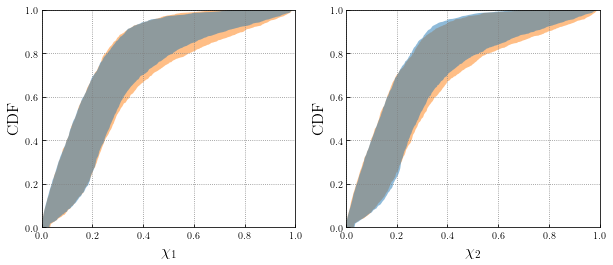

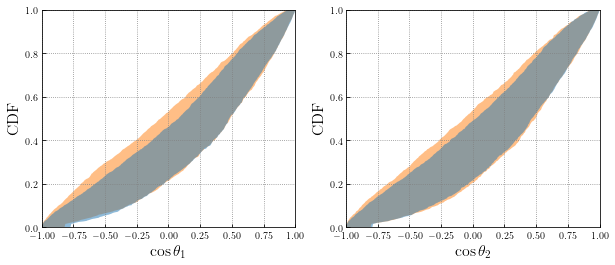

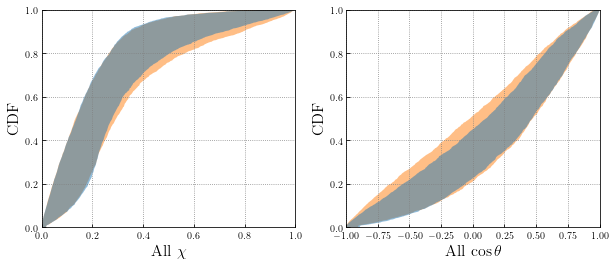

In [5]:
# Define a regular grid
chi_grid = np.linspace(0,1,300)
cost_grid = np.linspace(-1,1,300)

# Instantiate arrays to hold cdfs of component spin values over the above grid
observed_a1_cdf = np.zeros((nPops,chi_grid.size))
observed_a2_cdf = np.zeros((nPops,chi_grid.size))
observed_cost1_cdf = np.zeros((nPops,cost_grid.size))
observed_cost2_cdf = np.zeros((nPops,cost_grid.size))
predicted_a1_cdf = np.zeros((nPops,chi_grid.size))
predicted_a2_cdf = np.zeros((nPops,chi_grid.size))
predicted_cost1_cdf = np.zeros((nPops,cost_grid.size))
predicted_cost2_cdf = np.zeros((nPops,cost_grid.size))

# We can also build cdfs over the union of all component spins
observed_chi_cdf = np.zeros((nPops,chi_grid.size))
observed_cost_cdf = np.zeros((nPops,chi_grid.size))
predicted_chi_cdf = np.zeros((nPops,chi_grid.size))
predicted_cost_cdf = np.zeros((nPops,chi_grid.size))

# For each of our catalogs, compute CDFs
for i in range(nPops):
    
    cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    full_cdf_vals = np.cumsum(np.ones(2*len(sampleDict)))/(2.*len(sampleDict))
    
    observed_a1_cdf[i,:] = np.interp(chi_grid,np.sort(observed_a1s[i,:]),cdf_vals,left=0)
    observed_a2_cdf[i,:] = np.interp(chi_grid,np.sort(observed_a2s[i,:]),cdf_vals,left=0)
    observed_chi_cdf[i,:] = np.interp(chi_grid,np.sort(observed_chis[i,:]),full_cdf_vals,left=0)
    observed_cost1_cdf[i,:] = np.interp(cost_grid,np.sort(observed_cost1s[i,:]),cdf_vals,left=0)
    observed_cost2_cdf[i,:] = np.interp(cost_grid,np.sort(observed_cost2s[i,:]),cdf_vals,left=0)
    observed_cost_cdf[i,:] = np.interp(cost_grid,np.sort(observed_costs[i,:]),full_cdf_vals,left=0)
    
    predicted_a1_cdf[i,:] = np.interp(chi_grid,np.sort(predicted_a1s[i,:]),cdf_vals,left=0)
    predicted_a2_cdf[i,:] = np.interp(chi_grid,np.sort(predicted_a2s[i,:]),cdf_vals,left=0)
    predicted_chi_cdf[i,:] = np.interp(chi_grid,np.sort(predicted_chis[i,:]),full_cdf_vals,left=0)
    predicted_cost1_cdf[i,:] = np.interp(cost_grid,np.sort(predicted_cost1s[i,:]),cdf_vals,left=0)
    predicted_cost2_cdf[i,:] = np.interp(cost_grid,np.sort(predicted_cost2s[i,:]),cdf_vals,left=0)
    predicted_cost_cdf[i,:] = np.interp(cost_grid,np.sort(predicted_costs[i,:]),full_cdf_vals,left=0)
    
# Plot!
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.fill_between(chi_grid,
                np.quantile(observed_a1_cdf,0.05,axis=0),
                np.quantile(observed_a1_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(chi_grid,
                np.quantile(predicted_a1_cdf,0.05,axis=0),
                np.quantile(predicted_a1_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\chi_1$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)

ax = fig.add_subplot(122)
ax.fill_between(chi_grid,
                np.quantile(observed_a2_cdf,0.05,axis=0),
                np.quantile(observed_a2_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(chi_grid,
                np.quantile(predicted_a2_cdf,0.05,axis=0),
                np.quantile(predicted_a2_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\chi_2$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.fill_between(cost_grid,
                np.quantile(observed_cost1_cdf,0.05,axis=0),
                np.quantile(observed_cost1_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(cost_grid,
                np.quantile(predicted_cost1_cdf,0.05,axis=0),
                np.quantile(predicted_cost1_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\cos\\theta_1$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)

ax = fig.add_subplot(122)
ax.fill_between(cost_grid,
                np.quantile(observed_cost2_cdf,0.05,axis=0),
                np.quantile(observed_cost2_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(cost_grid,
                np.quantile(predicted_cost2_cdf,0.05,axis=0),
                np.quantile(predicted_cost2_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\cos\\theta_2$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

# Plot!
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.fill_between(chi_grid,
                np.quantile(observed_chi_cdf,0.05,axis=0),
                np.quantile(observed_chi_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(chi_grid,
                np.quantile(predicted_chi_cdf,0.05,axis=0),
                np.quantile(predicted_chi_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('All $\chi$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)

ax = fig.add_subplot(122)
ax.fill_between(cost_grid,
                np.quantile(observed_cost_cdf,0.05,axis=0),
                np.quantile(observed_cost_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(cost_grid,
                np.quantile(predicted_cost_cdf,0.05,axis=0),
                np.quantile(predicted_cost_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_xlabel('All $\cos\\theta$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

## Make predictive check figure

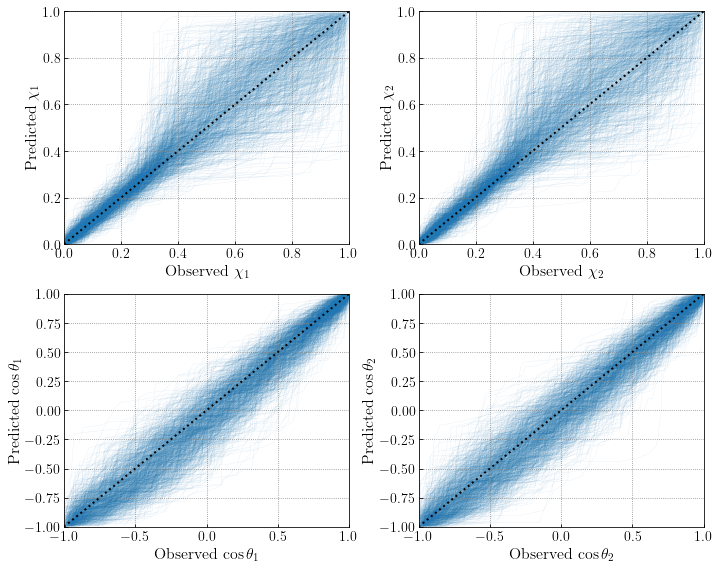

In [6]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(221)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_a1s[i,:]),
            np.sort(predicted_a1s[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([0,1],[0,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\chi_1$',fontsize=16)
ax.set_ylabel(r'Predicted $\chi_1$',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax = fig.add_subplot(222)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_a2s[i,:]),
            np.sort(predicted_a2s[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([0,1],[0,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\chi_2$',fontsize=16)
ax.set_ylabel(r'Predicted $\chi_2$',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax = fig.add_subplot(223)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_cost1s[i,:]),
            np.sort(predicted_cost1s[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([-1,1],[-1,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\cos\theta_1$',fontsize=16)
ax.set_ylabel(r'Predicted $\cos\theta_1$',fontsize=16)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ax = fig.add_subplot(224)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_cost2s[i,:]),
            np.sort(predicted_cost2s[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([-1,1],[-1,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\cos\theta_2$',fontsize=16)
ax.set_ylabel(r'Predicted $\cos\theta_2$',fontsize=16)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

plt.tight_layout()
plt.savefig('figure_22.pdf',bbox_inches='tight',dpi=200)
plt.show()

## Finally, quantify expected detections in the tails

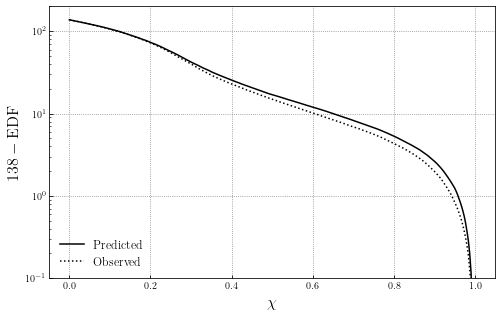

0.8486678601727361


In [7]:
# Plot the EDF of component spin magnitudes, integrating from large to small values
# Note that this needs to integrate to 138=2*69, since each of our 69 events gives two component spins
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(chi_grid,138-np.mean(predicted_chi_cdf,axis=0)*138,color='black',label='Predicted')
ax.plot(chi_grid,138-np.mean(observed_chi_cdf,axis=0)*138,color='black',ls=':',label='Observed')
ax.set_xlabel('$\chi$',fontsize=16)
ax.set_ylabel('$138-\mathrm{EDF}$',fontsize=16)
ax.legend(loc='lower left',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,200)
plt.show()

print(np.interp(4.,(138-np.mean(predicted_chi_cdf,axis=0)*138)[::-1],chi_grid[::-1]))

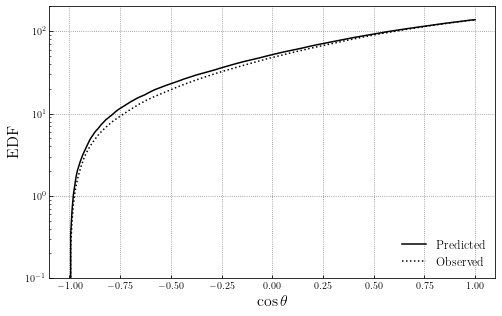

-0.9607542519690547
-0.9145318509913535


In [8]:
# Plot the EDF of cosine spin-tilt angles, integrating from small to large
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(cost_grid,np.mean(predicted_cost_cdf,axis=0)*138,color='black',label='Predicted')
ax.plot(cost_grid,np.mean(observed_cost_cdf,axis=0)*138,color='black',ls=':',label='Observed')
ax.set_xlabel('$\cos\\theta$',fontsize=16)
ax.set_ylabel('EDF',fontsize=16)
ax.legend(loc='lower right',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,200)
plt.show()

print(np.interp(2.,np.mean(predicted_cost_cdf,axis=0)*138,cost_grid))
print(np.interp(4.,np.mean(predicted_cost_cdf,axis=0)*138,cost_grid))

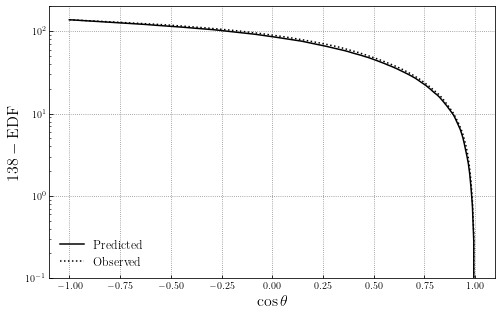

0.971641441186228
0.9494459014476907


In [9]:
# ...And integrating from right to left
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(cost_grid,138-np.mean(predicted_cost_cdf,axis=0)*138,color='black',label='Predicted')
ax.plot(cost_grid,138-np.mean(observed_cost_cdf,axis=0)*138,color='black',ls=':',label='Observed')
ax.set_xlabel('$\cos\\theta$',fontsize=16)
ax.set_ylabel('$138-\mathrm{EDF}$',fontsize=16)
ax.legend(loc='lower left',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,200)
plt.show()

print(np.interp(2.,(138-np.mean(predicted_cost_cdf,axis=0)*138)[::-1],cost_grid[::-1]))
print(np.interp(4.,(138-np.mean(predicted_cost_cdf,axis=0)*138)[::-1],cost_grid[::-1]))

In [10]:
# Save macros
with open('./../macros/component_spin_tails.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\ComponentMagTailHighTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,(138-np.mean(predicted_chi_cdf,axis=0)*138)[::-1],chi_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ComponentMagTailHighFour}}{{{0:.2f}}}".format(\
        np.interp(4.,(138-np.mean(predicted_chi_cdf,axis=0)*138)[::-1],chi_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ComponentTiltTailLowTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,np.mean(predicted_cost_cdf,axis=0)*138,cost_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ComponentTiltTailLowFour}}{{{0:.2f}}}".format(\
        np.interp(4.,np.mean(predicted_cost_cdf,axis=0)*138,cost_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ComponenttiltTailHighTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,(138-np.mean(predicted_cost_cdf,axis=0)*138)[::-1],cost_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ComponenttiltTailHighFour}}{{{0:.2f}}}".format(\
        np.interp(4.,(138-np.mean(predicted_cost_cdf,axis=0)*138)[::-1],cost_grid[::-1])
        ))
    macrofile.write("\n")